## METHODOLOGY
1. Subset Data 7-40 in length
2. Balance the data by random sampling, this is because there is more of the undetected class, the detected class is the minority.
3. Once dataset is balanced, integer encode the peptides. 
4. Test Train Split
5. Create the model
6. Fit the transformer
7. Evaluate the model (TP,TN,F1,FP,FN/ PRECISION/RECALL TRADE OFF,  Plot Confusion matrix etc)

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import time
import math
import re

import sklearn.model_selection
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

from transformer import TokenAndPositionEmbedding, TransformerBlock

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from textwrap import wrap
import seaborn as sns

In [2]:

# This script is required to run the transformer network models and should be present in the same directory.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Implement multi head self attention as a Keras layer.
"""


class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


"""
## Implement a Transformer block as a layer
"""


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


"""
## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).
"""


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions



## Import Data

In [3]:
df =  pd.read_csv('updated_quant_missed_cleaved_peptides_excluded.csv') # read in the data

In [4]:
df

,Sequence,Detectability,Protein,SMT,NSMT,NSMT_over_SC
0,AAAAAAAATMALAAPSSPTPESPTMLTK,1,INCENP,56437.600,0.000005,0.000053
1,AAAAAAAGDSDSWDADAFSVEDPVR,1,EIF3J,2270292.510,0.000686,0.000258
2,AAAAAAALQAK,1,RPL4,1979939.150,0.000362,0.000352
3,AAAAAAGAASGLPGPVAQGLK,1,IPO9,3547224.919,0.000266,0.000183
4,AAAAAAVGPGAGGAGSAVPGGAGPCATVSVFPGAR,1,CARM1,874337.160,0.000112,0.000207
...,...,...,...,...,...,...
158158,ILYALSTSK,0,ERAP2,1218369.700,0.000110,0.000266
158159,TQNLAALLHAIAR,0,ERAP2,1218369.700,0.000110,0.000266
158160,FDLGSYDIR,0,ERAP2,1218369.700,0.000110,0.000266
158161,MIISGTTAHFSSK,0,ERAP2,1218369.700,0.000110,0.000266


In [5]:
df.shape

(158163, 6)

In [6]:
df["Detectability"].sum() # number of detected peptides

37437

## Subset Peptide Sequences  between 7- 40 amino acids in length 

In [7]:
detected_peptides = df[df['Detectability'] == 1] # detected peptides

In [8]:
undetected_peptides = df[df['Detectability'] == 0] # undetected peptides

In [9]:
undetected_peptides.shape

(120726, 6)

In [10]:
detected_peptides.shape

(37437, 6)

In [11]:
detected_peptides = detected_peptides.loc[(detected_peptides["Sequence"].str.len()>=7) & 
                                          (detected_peptides["Sequence"].str.len()<=40)].reset_index(drop=True)

In [12]:
undetected_peptides = undetected_peptides.loc[(undetected_peptides["Sequence"].str.len()>=7) & 
                                              (undetected_peptides["Sequence"].str.len()<=40)].reset_index(drop=True)

## Random Sampling to Balance Data

In [13]:
detected_peptides.shape # number of detected peptides

(37428, 6)

In [14]:
undetected_peptides.shape

(117899, 6)

In [15]:
# undetected peptides balanced by number of rows of detected peptides..
undetected_peptides_balanced = undetected_peptides.sample(n=detected_peptides.shape[0], 
                                                         random_state=42).reset_index(drop=True)

In [16]:
unused_undetected = undetected_peptides[~undetected_peptides["Sequence"].isin
                                        (undetected_peptides_balanced["Sequence"])]
unused_undetected.shape

(80471, 6)

## drop unnessesary columns 

In [17]:
detected_peptides.drop(columns='Protein', axis=1, inplace=True)
undetected_peptides_balanced.drop(columns='Protein', axis=1 ,inplace=True)

In [18]:
detected_peptides

,Sequence,Detectability,SMT,NSMT,NSMT_over_SC
0,AAAAAAAATMALAAPSSPTPESPTMLTK,1,5.643760e+04,0.000005,0.000053
1,AAAAAAAGDSDSWDADAFSVEDPVR,1,2.270293e+06,0.000686,0.000258
2,AAAAAAALQAK,1,1.979939e+06,0.000362,0.000352
3,AAAAAAGAASGLPGPVAQGLK,1,3.547225e+06,0.000266,0.000183
4,AAAAAAVGPGAGGAGSAVPGGAGPCATVSVFPGAR,1,8.743372e+05,0.000112,0.000207
...,...,...,...,...,...
37423,YYTGNYDQYVK,1,1.628988e+06,0.000204,0.000211
37424,YYTLEEIQK,1,2.352099e+05,0.000137,0.000167
37425,YYTLFGR,1,1.353858e+07,0.000698,0.000241
37426,YYTSASGDEMVSLK,1,1.708469e+07,0.001820,0.000215


In [19]:
undetected_peptides

,Sequence,Detectability,Protein,SMT,NSMT,NSMT_over_SC
0,MSAESGPGTR,0,BRD4,150547.0,0.00001,0.000214
1,QTNQLQYLLR,0,BRD4,150547.0,0.00001,0.000214
2,HQFAWPFQQPVDAVK,0,BRD4,150547.0,0.00001,0.000214
3,LNLPDYYK,0,BRD4,150547.0,0.00001,0.000214
4,TPMDMGTIK,0,BRD4,150547.0,0.00001,0.000214
...,...,...,...,...,...,...
117894,ILYALSTSK,0,ERAP2,1218369.7,0.00011,0.000266
117895,TQNLAALLHAIAR,0,ERAP2,1218369.7,0.00011,0.000266
117896,FDLGSYDIR,0,ERAP2,1218369.7,0.00011,0.000266
117897,MIISGTTAHFSSK,0,ERAP2,1218369.7,0.00011,0.000266


# Split into Train and Test Sets 

In [20]:
# detected peptides
X_trainP, X_testP, y_trainP, y_testP = sklearn.model_selection.train_test_split(
    detected_peptides, detected_peptides['Detectability'], test_size=0.3, random_state=42)

In [21]:
 #undetected peptides
X_trainN, X_testN, y_trainN, y_testN = sklearn.model_selection.train_test_split(
    undetected_peptides_balanced, undetected_peptides_balanced['Detectability'], test_size=0.3, random_state=42)

In [22]:
print(X_trainP.shape)
print(X_testP.shape)
print('')
print(X_trainN.shape)
print(X_testN.shape)

(26199, 5)
(11229, 5)

(26199, 5)
(11229, 5)


# split training into train and validation sets 

In [23]:
# detected peptides
X_trainP, X_valP, y_trainP, y_valP = sklearn.model_selection.train_test_split(
    X_trainP, y_trainP, test_size=0.3, random_state=42)

In [24]:
# undetected peptides
X_trainN, X_valN, y_trainN, y_valN = sklearn.model_selection.train_test_split(
    X_trainN, y_trainN, test_size=0.3, random_state=42) 

In [25]:
print(X_trainP.shape)
print(X_valP.shape)
print('')
print(X_trainN.shape)
print(X_valN.shape)

(18339, 5)
(7860, 5)

(18339, 5)
(7860, 5)


In [26]:
# create final training and validation sets 
X_train = pd.concat([X_trainP, X_trainN])
X_val = pd.concat([X_valP] + [X_valN])
y_train = pd.concat([pd.Series(y_trainP)] + [pd.Series(y_trainN)])
y_val = pd.concat([pd.Series(y_valP)] + [pd.Series(y_valN)])

In [27]:
print(X_train.shape)
print(X_val.shape)
print('')
print(y_train.shape)
print(y_val.shape)

(36678, 5)
(15720, 5)

(36678,)
(15720,)


In [28]:
X_train

,Sequence,Detectability,SMT,NSMT,NSMT_over_SC
17275,ISLSNESNK,1,14246270.20,1.311817e-03,0.000226
28185,SGLLVLTTPLASLAPR,1,637836.23,8.820348e-05,0.000130
15691,IEDTVFHVFDK,1,774966.20,6.309179e-05,0.000157
24100,NFNAVGSVLSK,1,106108.63,1.426850e-05,0.000101
25929,QEIIQDLAAMVR,1,1093847.58,9.931601e-05,0.000141
...,...,...,...,...,...
14327,VAYTTVLQEWLR,0,265244.41,2.690401e-05,0.000069
32264,ISADTHQFSVTER,0,163593.40,3.745629e-05,0.000155
12850,ADVAVESLIPGLEPPVPQR,0,681542.86,6.121673e-05,0.000176
29212,HIGVCISVANNR,0,7036359.47,9.749005e-04,0.000294


In [29]:
# check validation set is not in train
print(len(X_val[X_val["Sequence"].isin(X_train["Sequence"])]))

0


# create final test set 

In [30]:
# create final test set
X_test = pd.concat([X_testP, X_testN])
y_test = pd.concat([pd.Series(y_testP)] + [pd.Series(y_testN)])
print(X_test.shape)
print(y_test.shape)

(22458, 5)
(22458,)


In [31]:
# check test is not in train or validation
print(len(X_test[X_test["Sequence"].isin(X_val["Sequence"])]))
print(len(X_test[X_test["Sequence"].isin(X_train["Sequence"])]))

0
0


## Integer encode Raw  Peptide Sequences for Transformer

In [32]:

max_length = 40
def convertPeptide(peptide_sequence, max_length): # set the maximum length of the peptide sequence
    amino_acid = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17,'U':18, 'V': 19, 'W': 20, 'Y': 21} # create a dictionary of amino acids
    integer = [] # initialize an empty list
    for i in range(max_length):
        if i < len(peptide_sequence): #if the index is less than the length of the peptide sequence
            integer.append(amino_acid[peptide_sequence[i]]) #append the value of the amino acid at the index to the integer
        else: #if the index is greater than the length of the peptide sequence
            integer.append(0) #append zero to the integer list
    return np.array(integer)#return the integer as a numpy array


### Shuffle the data inputs

In [33]:
X_train = shuffle(X_train, random_state=42).reset_index(drop=True)
y_train = shuffle(y_train, random_state=42).reset_index(drop=True)

In [34]:
X_val = shuffle(X_val, random_state=42).reset_index(drop=True)
y_val = shuffle(y_val, random_state=42).reset_index(drop=True)

In [35]:
X_test = shuffle(X_test, random_state=42).reset_index(drop=True)
y_test = shuffle(y_test, random_state=42).reset_index(drop=True)

## Separate out the features 

In [36]:
X_train_peptide = X_train['Sequence'].apply(convertPeptide, args=(max_length,))

In [37]:
X_train_peptide # the training set is now a series of numpy arrays

0        [20, 5, 19, 19, 10, 4, 4, 17, 13, 20, 3, 1, 17...
1        [1, 12, 4, 1, 21, 13, 2, 13, 2, 3, 8, 6, 7, 15...
2        [19, 3, 19, 4, 1, 10, 4, 12, 16, 1, 6, 1, 17, ...
3        [6, 11, 6, 11, 12, 16, 13, 4, 10, 10, 10, 10, ...
4        [10, 13, 10, 10, 15, 13, 16, 1, 12, 7, 17, 19,...
                               ...                        
36673    [8, 14, 1, 6, 4, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0,...
36674    [1, 1, 16, 3, 4, 10, 16, 9, 0, 0, 0, 0, 0, 0, ...
36675    [4, 16, 19, 14, 6, 21, 17, 17, 9, 0, 0, 0, 0, ...
36676    [17, 13, 16, 21, 16, 8, 16, 16, 17, 10, 12, 13...
36677    [7, 6, 10, 4, 19, 8, 21, 11, 8, 4, 13, 8, 3, 4...
Name: Sequence, Length: 36678, dtype: object

In [38]:

X_train_quant= X_train.iloc[:,3] # get the quantitative features for the training set


In [39]:
X_train_quant = X_train_quant.to_frame()    # convert the series to a numpy array

In [40]:
# X_train_quant['log'] = (X_train_quant['SMT'] + 1).transform(np.log)

In [41]:
# X_train_quant.drop(columns='SMT', inplace=True)

In [42]:
X_train_quant

,NSMT
0,0.000006
1,0.000403
2,0.000433
3,0.000057
4,0.000029
...,...
36673,0.000074
36674,0.001057
36675,0.000164
36676,0.000164


In [43]:
# X_train_quant = X_train_quant.to_numpy() # convert the series to a numpy array

In [44]:
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = MinMaxScaler()

In [46]:
X_train_quant = scaler.fit_transform(X_train_quant)

In [47]:
X_train_quant = X_train_quant.flatten()

In [48]:
X_val_peptide = X_val['Sequence'].apply(convertPeptide, args=(max_length,)) # get the encoded peptide sequences for the validation set

In [49]:
X_val_peptide # validation set

0        [1, 11, 10, 16, 4, 14, 12, 15, 0, 0, 0, 0, 0, ...
1        [17, 19, 10, 19, 16, 16, 6, 10, 15, 0, 0, 0, 0...
2        [19, 1, 6, 13, 13, 8, 10, 12, 13, 8, 1, 12, 4,...
3        [7, 8, 16, 4, 16, 7, 4, 9, 0, 0, 0, 0, 0, 0, 0...
4        [12, 13, 4, 8, 16, 7, 11, 10, 12, 12, 13, 3, 8...
                               ...                        
15715    [8, 19, 1, 16, 11, 20, 3, 16, 10, 6, 4, 4, 14,...
15716    [1, 20, 13, 13, 17, 17, 19, 7, 0, 0, 0, 0, 0, ...
15717    [3, 19, 1, 10, 1, 10, 1, 1, 10, 3, 6, 6, 15, 0...
15718    [1, 1, 17, 13, 17, 10, 17, 17, 5, 13, 17, 8, 1...
15719    [21, 16, 4, 4, 6, 19, 21, 12, 19, 14, 21, 16, ...
Name: Sequence, Length: 15720, dtype: object

In [50]:
X_val_quant = X_val.iloc[:,3] # get the quantitative values for the validation set

In [51]:
X_val_quant = X_val_quant.to_frame() # convert the series to a numpy array

In [52]:
# X_val_quant['log'] = (X_val_quant['SMT'] +1).transform(np.log) # log the quantitative values

In [53]:
# X_val_quant.drop(columns='SMT', inplace=True) # drop the SMT column

In [54]:
X_val_quant # validation set with quantitative values

,NSMT
0,0.000004
1,0.000012
2,0.000075
3,0.000067
4,0.000056
...,...
15715,0.000014
15716,0.000014
15717,0.000102
15718,0.000072


In [55]:
X_val_quant = scaler.transform(X_val_quant).flatten() # scale the quantitative values for the validation set

In [56]:
X_test_peptide = X_test['Sequence'].apply(convertPeptide, args=(max_length,)) # get the encoded peptide sequences for the test set

In [57]:
X_test_peptide # test set

0        [4, 9, 13, 16, 3, 13, 19, 4, 20, 17, 19, 11, 3...
1        [10, 12, 8, 10, 3, 17, 10, 16, 9, 0, 0, 0, 0, ...
2        [19, 19, 17, 14, 12, 8, 2, 14, 21, 15, 0, 0, 0...
3        [6, 3, 8, 3, 7, 19, 9, 0, 0, 0, 0, 0, 0, 0, 0,...
4        [8, 4, 6, 17, 13, 10, 4, 17, 8, 14, 9, 0, 0, 0...
                               ...                        
22453    [1, 3, 3, 19, 15, 13, 4, 19, 17, 20, 16, 5, 16...
22454    [16, 10, 19, 14, 3, 10, 9, 0, 0, 0, 0, 0, 0, 0...
22455    [1, 10, 16, 14, 10, 1, 4, 19, 4, 4, 9, 0, 0, 0...
22456    [19, 8, 14, 4, 8, 19, 3, 9, 0, 0, 0, 0, 0, 0, ...
22457    [10, 10, 16, 14, 3, 5, 19, 14, 8, 11, 4, 3, 8,...
Name: Sequence, Length: 22458, dtype: object

In [58]:
X_test_quant = X_test.iloc[:,3]  # get the quantitative values for the test set


In [59]:
X_test_quant = X_test_quant.to_frame() # convert the series to a df

In [60]:
X_test_quant = scaler.transform(X_test_quant).flatten() # scale the quantitative values for the test set

In [61]:
X_test_quant

array([0.00054496, 0.06079764, 0.00209951, ..., 0.04889889, 0.04003264,
       0.0770491 ])

In [62]:
# X_test_quant['log'] = (X_test_quant['SMT'] +1).transform(np.log) # log the SMT values

In [63]:
# X_test_quant.drop(columns='SMT', inplace=True) # drop the SMT column

In [64]:
# X_test_quant = X_test_quant.to_numpy().flatten() # convert the series to a numpy array

In [65]:
# convert the quantitative values to numpy arrays
X_train_peptide = np.array(X_train_peptide.to_list()) # convert the series to a numpy array for the training set

In [66]:
X_val_peptide = np.array(X_val_peptide.to_list()) # convert the series to a numpy array for the validation set

In [67]:
X_test_peptide = np.array(X_test_peptide.to_list()) # convert the series to a numpy array for the test set

In [68]:
X_train_peptide[0] # (the first peptide sequence, with the integer coversion applied)

array([20,  5, 19, 19, 10,  4,  4, 17, 13, 20,  3,  1, 17, 16,  7,  8,  3,
       12, 11,  4, 12,  4, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [69]:
X_train_peptide[9][:40] # take 40 amino acids of the 9th peptide, peptides < 40 are appended with 0s.

array([ 8, 19,  1,  4,  2, 12,  1, 19, 15,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [70]:
# import EarlyStopping from keras
from tensorflow.keras.callbacks import EarlyStopping

In [71]:
# help(EarlyStopping)

In [72]:
early_stop = EarlyStopping(monitor='val_loss',  mode = 'min', patience=50, verbose=1) # set the early stopping parameters to monitor the validation loss and minimize the loss

### BUILD (REPORTER (rm) ITENSTIY QUANTIFICATION)

In [73]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32 # Hidden layer size in feed forward network inside transformer

main_input = tf.keras.layers.Input(shape=(40,), name= 'sequence')
# embed each peptide into a 40-dimensional vector
embedding_layer = TokenAndPositionEmbedding(40, 22, embed_dim) # create a token and position embedding layer
x = embedding_layer(main_input) # apply the token and position embedding layer to the main input
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim) # create a transformer block
x = transformer_block(x) # apply the transformer block to the embedding layer

y = tf.keras.layers.GlobalAveragePooling1D()(x) # apply global average pooling to the transformer block output
auxiliary_output = tf.keras.layers.Dense(1, activation='sigmoid', name = 'aux_output')(y)
 # apply a dense layer to the output of the transformer block, y is the output of the global average pooling layer
 # create a dense layer with 1 output for the auxiliary output
auxiliary_input = tf.keras.layers.Input(shape=(1,), name='reporter_ion_quant') # create an input layer for the auxiliary input




# concatenate the output of the transformer block and the auxiliary input
x = tf.keras.layers.concatenate([auxiliary_output, auxiliary_input]) 




x = tf.keras.layers.Dense(64, activation='relu')(x) # apply a dense layer to the concatenated output of the transformer block and the auxiliary input
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)


main_output = tf.keras.layers.Dense(1, activation='sigmoid', name='main_output') (x) # apply a dense layer to the output of the dense layer, x is the output of the dense layer

model = tf.keras.Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output]) # create a model (defining it here because we need to specify the input and output layers)


optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 

model.compile(loss='binary_crossentropy', optimizer= optimiser, metrics=['accuracy'], loss_weights= [1.,0.2]) # compile the model

2022-07-25 15:48:08.043479: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 15:48:08.044554: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 40, 32)       1984        sequence[0][0]                   
__________________________________________________________________________________________________
transformer_block (TransformerB (None, 40, 32)       6464        token_and_position_embedding[0][0
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 32)           0           transformer_block[0][0]          
______________________________________________________________________________________________

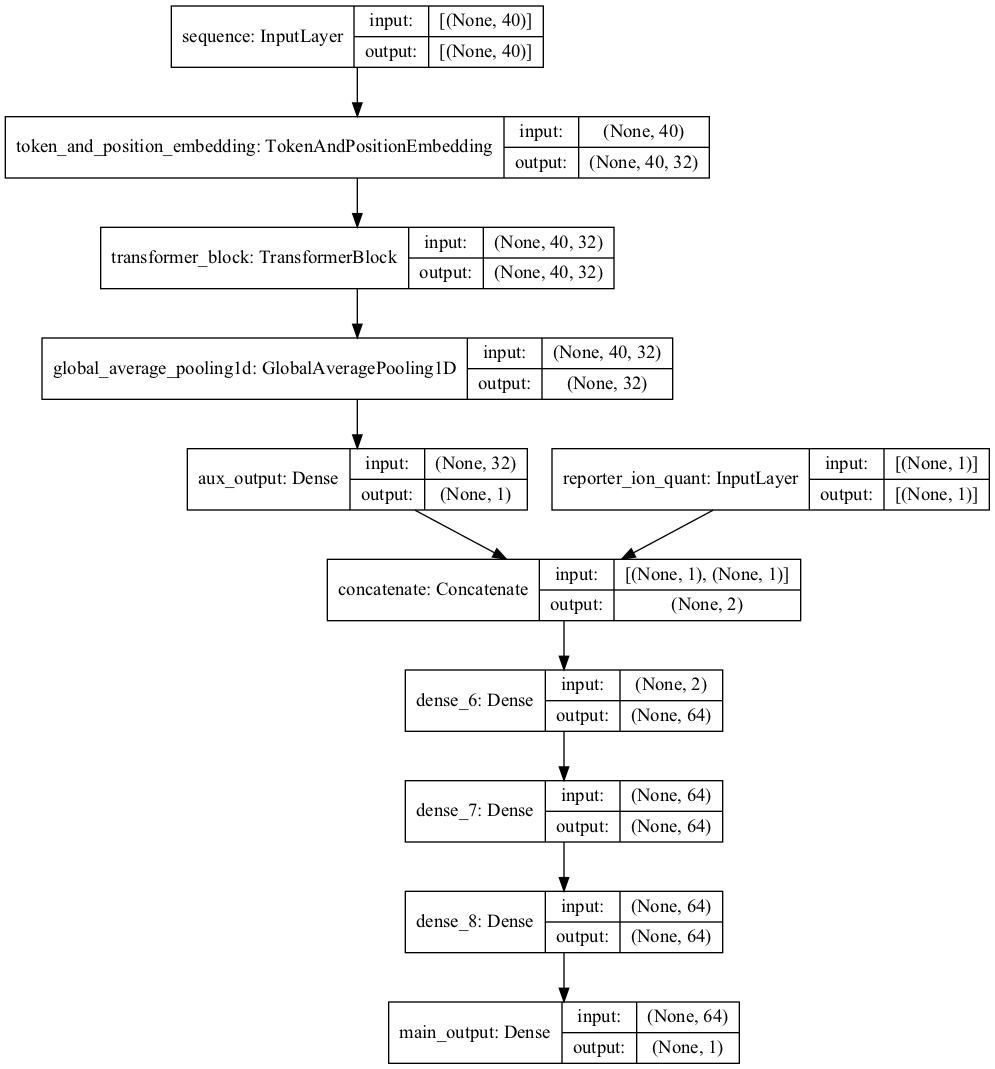

In [74]:
print(model.summary())
keras.utils.plot_model(model, "keras_model_sequence_SRI20date.png", show_shapes=True, show_layer_names=True) #PLOT ARCHITECTURE


In [75]:
y_train = y_train.to_numpy() # convert the series to a numpy array

In [76]:
y_val = y_val.to_numpy() # convert the series to a numpy array

In [77]:
# X_val_quant = X_val_quant.to_numpy() # convert the series to a numpy array

In [78]:
# X_val_quant = X_val_quant.flatten() # flatten the numpy array

In [79]:
# X_train_quant = X_train_quant.to_numpy().flatten() # convert the series to a numpy array

In [80]:
start_time = time.time()

history_model = model.fit([X_train_peptide, X_train_quant],  [y_train,y_train], validation_data= ([X_val_peptide, X_val_quant],[y_val,y_val]), callbacks=[early_stop] ,epochs=350, batch_size=128, verbose=2) # train the model with y_train and y_val as the labels
print("")
print("Training time: ", time.time() - start_time)

Train on 36678 samples, validate on 15720 samples
Epoch 1/350
36678/36678 - 26s - loss: 0.8228 - main_output_loss: 0.6871 - aux_output_loss: 0.6785 - main_output_accuracy: 0.6179 - aux_output_accuracy: 0.5600 - val_loss: 0.8103 - val_main_output_loss: 0.6784 - val_aux_output_loss: 0.6594 - val_main_output_accuracy: 0.6557 - val_aux_output_accuracy: 0.6077
Epoch 2/350
36678/36678 - 22s - loss: 0.7740 - main_output_loss: 0.6446 - aux_output_loss: 0.6461 - main_output_accuracy: 0.7065 - aux_output_accuracy: 0.6242 - val_loss: 0.7261 - val_main_output_loss: 0.5984 - val_aux_output_loss: 0.6383 - val_main_output_accuracy: 0.7116 - val_aux_output_accuracy: 0.6360
Epoch 3/350
36678/36678 - 21s - loss: 0.6911 - main_output_loss: 0.5637 - aux_output_loss: 0.6364 - main_output_accuracy: 0.7208 - aux_output_accuracy: 0.6339 - val_loss: 0.6754 - val_main_output_loss: 0.5477 - val_aux_output_loss: 0.6383 - val_main_output_accuracy: 0.7271 - val_aux_output_accuracy: 0.6352
Epoch 4/350
36678/36678 - 

In [81]:
history_model

In [82]:
model_loss = pd.DataFrame(history_model.history)

In [83]:
model_loss

,loss,main_output_loss,aux_output_loss,main_output_accuracy,aux_output_accuracy,val_loss,val_main_output_loss,val_aux_output_loss,val_main_output_accuracy,val_aux_output_accuracy
0,0.822802,0.687073,0.678507,0.617864,0.559981,0.810283,0.678390,0.659437,0.655725,0.607697
1,0.773994,0.644649,0.646086,0.706527,0.624243,0.726112,0.598430,0.638272,0.711641,0.636005
2,0.691077,0.563747,0.636374,0.720814,0.633895,0.675366,0.547682,0.638287,0.727099,0.635242
3,0.656110,0.530331,0.629031,0.736354,0.640847,0.652415,0.527469,0.624772,0.739822,0.647137
4,0.643003,0.517574,0.626886,0.744915,0.643219,0.644680,0.519562,0.625608,0.748092,0.647392
...,...,...,...,...,...,...,...,...,...,...
317,0.502659,0.392881,0.549763,0.822373,0.707918,0.531776,0.419154,0.562696,0.803499,0.694784
318,0.502301,0.392383,0.549878,0.821773,0.708054,0.533383,0.420724,0.563227,0.802990,0.695992
319,0.501459,0.391711,0.548991,0.821964,0.708954,0.530179,0.417905,0.561061,0.804198,0.697265
320,0.501963,0.392078,0.549221,0.821910,0.708327,0.532865,0.420329,0.562218,0.804135,0.696374


In [84]:
model_loss.to_csv("model_loss_sequence_min_max_NSRI_new_25date.csv") # save the model loss to a csv file for the sequence model

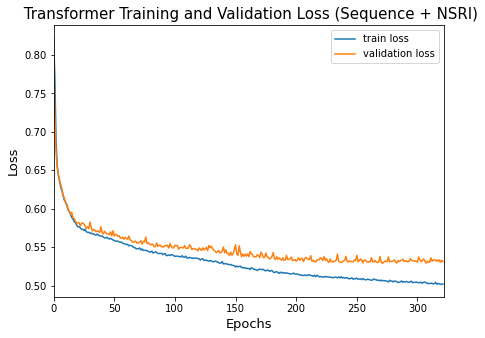

In [85]:
# plot the model loss and training loss against the number of epochs
# enlarge the figure size to make it easier to see
plt.figure(figsize=(7,5))
plt.plot(model_loss['loss'])
plt.plot(model_loss['val_loss'])
plt.title(' Transformer Training and Validation Loss (Sequence + NSRI)', fontsize=15)
plt.ylabel('Loss', fontsize=13)
plt.xlabel('Epochs', fontsize=13)
plt.legend(['train loss', 'validation loss'], loc='upper right', fontsize=10)
# x limit for the loss plot to 192
plt.xlim(0,322)


#plt.savefig('Transformer__Training_Val_loss_sequence_SMT_noise_07data128batches.png', dpi=300)
plt.show()



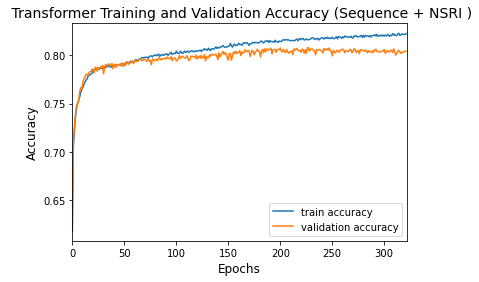

In [86]:
# plot the model training and validation accuracy against the number of epochs
plt.plot(model_loss['main_output_accuracy'])
plt.plot(model_loss['val_main_output_accuracy'])
# enlarge the text size to make it easier to see
plt.title(' Transformer Training and Validation Accuracy (Sequence + NSRI )', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', fontsize=10)
# x limit for the accuracy plot to 192
plt.xlim(0, 322)
#plt.savefig('Transformer_Training_Val_accuracy_sequence_SMT_noise_07.png', dpi=300)
plt.show()


## Save Model

In [87]:
# save the model to a h5 file
history_model.model.save('model_sequence_NSRI_min_max_25date') 

2022-07-25 17:54:49.627949: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_sequence_NSRI_min_max_25date/assets


In [88]:
train_results = model.evaluate([X_train_peptide, X_train_quant],[y_train,y_train]) # evaluate the model on the training data )
print("")
print("Training results: ", train_results)


36678/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
train_results

In [89]:
val_results = model.evaluate([X_val_peptide,X_val_quant], [y_val, y_val]) # evaluate the model on the validation data
print("")
print("Validation results: ", val_results)

15720/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Model Prediction 

In [90]:
Model_prediction_df = pd.DataFrame({'Peptide': X_test['Sequence'], 'Detectability': y_test})

In [91]:
Model_prediction_df

,Peptide,Detectability
0,EKPSDPVEWTVMDVVEYFTEAGFPEQATAFQEQEIDGK,0
1,LNILDTLSK,1
2,VVTQNICQYR,1
3,GDIDHVK,1
4,IEGTPLETIQK,1
...,...,...
22453,ADDVRPEVTWSFSR,0
22454,SLVQDLK,0
22455,ALSQLAEVEEK,1
22456,VIQEIVDK,1


In [92]:
test_predictions =model.predict([np.array([convertPeptide(x, max_length) for x in Model_prediction_df['Peptide']]), np.array(X_test_quant)],  verbose=1)

22458/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [93]:
Model_prediction_df['Prediction'] = test_predictions[0].flatten()

In [ ]:
Model_prediction_df.reset_index(drop=True, inplace=True)

In [94]:
Model_prediction_df

,Peptide,Detectability,Prediction
0,EKPSDPVEWTVMDVVEYFTEAGFPEQATAFQEQEIDGK,0,0.010448
1,LNILDTLSK,1,0.921618
2,VVTQNICQYR,1,0.261266
3,GDIDHVK,1,0.968003
4,IEGTPLETIQK,1,0.901281
...,...,...,...
22453,ADDVRPEVTWSFSR,0,0.283398
22454,SLVQDLK,0,0.055714
22455,ALSQLAEVEEK,1,0.929779
22456,VIQEIVDK,1,0.865217


In [95]:
# save the model predictions to a csv file
Model_prediction_df.to_csv("model_predictions_sequence_min_max_NSRI_no_missed_cleaved_20date.csv", sep="\t", index=False)

In [2]:
# read the model predictions from a csv file if needed
Model_prediction_df = pd.read_csv("model_predictions_sequence_min_max_NSRI_no_missed_cleaved_20date.csv", sep="\t")

In [3]:
import seaborn as sns

In [4]:
 colors = ["#9f04ff", "#ffa304"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


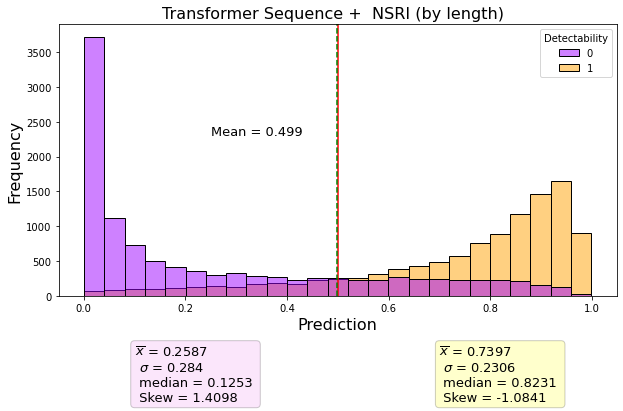

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.legend( loc='upper left', bbox_to_anchor=(1, 1))
sns.histplot(data=Model_prediction_df, x=Model_prediction_df['Prediction'], hue=Model_prediction_df['Detectability'], palette= colors , stat='count', bins=25)
ax.set_title('Transformer Sequence +  NSRI (by length)  ', fontsize=16)

ax.set_xlabel('Prediction', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)


plt.axvline(x=Model_prediction_df['Detectability'].mean(), color='r')
plt.axvline(x=Model_prediction_df['Prediction'].mean(), color='g', ls='--')
plt.text(0.25,2300, ('Mean = {:.3f}'.format(Model_prediction_df['Prediction'].mean())), fontsize=13)
# put text on the plot

skew = round(((Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].mean() - Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].median()) * 3)/( Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].std()), 4)
mean = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].mean(), 4)
median = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].median(), 4)


sd = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 1, 'Prediction'].std(), 4)

textstr = "$\overline {x}$" + f" = {mean} \n $\sigma$ = {sd} \n median = {median} \n Skew = {skew}"
props = dict(boxstyle='round', facecolor='yellow', alpha=0.2)
plt.text(0.7,-1500, textstr, fontsize=13, bbox = props)


skew = round(((Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].mean() - Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].median()) * 3)/( Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].std()), 4)
mean = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].mean(), 4)
median = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].median(), 4)

# get the mode of the data where prediction is 1

sd = round(Model_prediction_df.loc[Model_prediction_df['Detectability'] == 0, 'Prediction'].std(), 4)
textstr = "$\overline {x}$" + f" = {mean} \n $\sigma$ = {sd} \n median = {median} \n Skew = {skew}"
props = dict(boxstyle='round', facecolor='violet', alpha=0.2)
plt.text(0.1,-1500, textstr, fontsize=13, bbox = props)

plt.savefig('Transformer_model_predictions_sequence_freq_min_max_scaled_SRI_noise_new_20date.png', dpi=300, bbox_inches='tight')

In [99]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(Model_prediction_df['Prediction']))

In [100]:
# get the classification report and plot confusion matrix

print(sklearn.metrics.classification_report(y_test, np.rint(Model_prediction_df['Prediction'])))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     11229
           1       0.79      0.84      0.81     11229

    accuracy                           0.81     22458
   macro avg       0.81      0.81      0.81     22458
weighted avg       0.81      0.81      0.81     22458



In [101]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.rint(Model_prediction_df['Prediction']))

0.8056817169828123

In [102]:
from sklearn.metrics import recall_score
recall_score(y_test, round(Model_prediction_df['Prediction']), average='binary')

0.8398788850298334

In [103]:
from sklearn import metrics
MCC = metrics.matthews_corrcoef(y_test, np.rint(Model_prediction_df['Prediction']))
print("MCC:",MCC)


MCC: 0.6127983836370258


In [104]:
from sklearn.metrics import f1_score
f1_score(y_test, np.rint(Model_prediction_df['Prediction']), average='binary')

0.8121071213295445

In [105]:
from sklearn.metrics import precision_score
precision_score(y_test, np.rint(Model_prediction_df['Prediction']), average='binary')

0.786113194965408

In [104]:
import seaborn as sns
from matplotlib import pyplot as plt


In [ ]:
test_predictions[0]

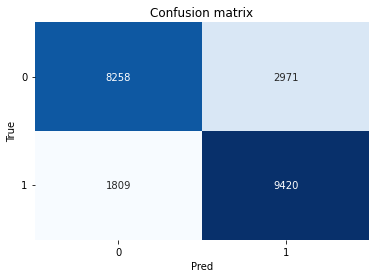

In [105]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
#cm = confusion_matrix(y_test,  , labels=classes)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.savefig('Transformer_sequence__SRI_min_max_confusion_no_missed_cleaved_matrix_20date.png', dpi=200)
plt.show()

In [8]:
def get_confusion_matrix_scores(df, peptide_col_index, true_col_index, pred_col_index): # df is the dataframe, peptide_col_index is the index of the peptide column, true_col_index is the index of the true column, pred_col_index is the index of the predicted column
    scores_df = df.iloc[: , [peptide_col_index, true_col_index, pred_col_index]].copy() # create a copy of the dataframe
    scores_df['pred_round'] = np.rint(scores_df.iloc[:, 2]).astype(int) # round to nearest integer
    scores_df['Length'] = scores_df.iloc[:, 0].str.len() # get length of peptide
    # count the number of missed cleavages, ignoring the last character of the peptide
    scores_df['Missed Cleavages'] = scores_df.iloc[:, 0].str.slice(0, -1).str.count('K') + scores_df.iloc[:, 0].str.slice(0, -1).str.count('R') # get the number of missed cleavages
    scores_df['pred_class'] = 0 # 0 = false, 1 = true
    # set the pred_class to 1 if the predicted class is the same as the true class
    scores_df.loc[(scores_df.iloc[:, 1] == 1) & (scores_df['pred_round'] == 1), 'pred_class'] = 'TP' # true positive # if the true class is 1 and the predicted class is 1
    scores_df.loc[(scores_df.iloc[:, 1] == 1) & (scores_df['pred_round'] == 0), 'pred_class'] = 'FN' # false negative # if the true class is 1 and the predicted class is 0
    scores_df.loc[(scores_df.iloc[:, 1] == 0) & (scores_df['pred_round'] == 0), 'pred_class'] = 'TN' # TN = true negative
    scores_df.loc[(scores_df.iloc[:, 1] == 0) & (scores_df['pred_round'] == 1), 'pred_class'] = 'FP' # FP = false positive

    scores_df['TP'] = 0 # initialize TP, FN, TN, FP columns
    scores_df['FN'] = 0
    scores_df['TN'] = 0
    scores_df['FP'] = 0

    scores_df.loc[(scores_df.iloc[:, 1] == 1) & (scores_df['pred_round'] == 1), 'TP'] = 1 # true positive
    scores_df.loc[(scores_df.iloc[:, 1] == 1) & (scores_df['pred_round'] == 0), 'FN'] = 1
    scores_df.loc[(scores_df.iloc[:, 1] == 0) & (scores_df['pred_round'] == 0), 'TN'] = 1 
    scores_df.loc[(scores_df.iloc[:, 1] == 0) & (scores_df['pred_round'] == 1), 'FP'] = 1

    # calculate the accuracy
  #  scores_df['Accuracy'] = (scores_df['TP'] + scores_df['TN']) / (scores_df['TP'] + scores_df['TN'] + scores_df['FP'] + scores_df['FN'])


    return scores_df


In [9]:
x = get_confusion_matrix_scores(Model_prediction_df, 0, 1, 2)

In [10]:
def get_acc_by_peptide_len(df):
    columns = ['Length', 'TP', 'FN', 'TN', 'FP']
    peptide_len_df = pd.DataFrame(columns=columns)

    for i in range(7, 41):
        test = df[df['Peptide'].str.len() == i]

        lenTP = test['TP'].sum()
        lenFN = test['FN'].sum()
        lenTN = test['TN'].sum()
        lenFP = test['FP'].sum()

        data = [i, lenTP, lenFN, lenTN, lenFP]
        peptide_len_df.loc[i - 7] = data

    peptide_len_df['Acc'] = (peptide_len_df['TP'] + peptide_len_df['TN']) / (peptide_len_df['TP'] + peptide_len_df['TN'] +
                                                                             peptide_len_df['FP'] + peptide_len_df['FN'])

    return peptide_len_df


In [11]:
acc_by_len = get_acc_by_peptide_len(x)

In [12]:
acc_by_len # get the accuracy by peptide length

,Length,TP,FN,TN,FP,Acc
0,7,821,254,1134,251,0.794715
1,8,993,209,859,272,0.793828
2,9,1021,169,705,237,0.809568
3,10,938,156,619,220,0.805484
4,11,855,145,492,225,0.784508
5,12,716,105,456,188,0.8
6,13,634,110,460,146,0.81037
7,14,557,108,373,144,0.786802
8,15,461,74,276,106,0.803708
9,16,449,60,300,104,0.820372


In [113]:
acc_by_len.to_csv('sequence_standardised_nsri_min_max_accuracy_no_missed_cleaved_by_length_for_transformerdate_22.csv', sep='\t', index=False) # saved the accuracy by peptide length to a csv file

In [ ]:
plt.clf()
plt.figure(figsize=(12.5, 2.56))

plt.plot(acc_by_len['Length'], acc_by_len['Acc'], color='tab:red', label='Sequence Feature')


plt.title('Accuracy Trend over Peptide Length for the Transformer Sequence Model', fontsize=13)
plt.xlabel('Peptide Length (aa)', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.legend(loc='best', ncol=1)
plt.savefig('Accuracy_Trend__missed_cleaved_SMT_over_length_for_the_Transformer_model_20.png', dpi=200, bbox_inches='tight')
plt.show()


In [14]:
from matplotlib.colors import ListedColormap

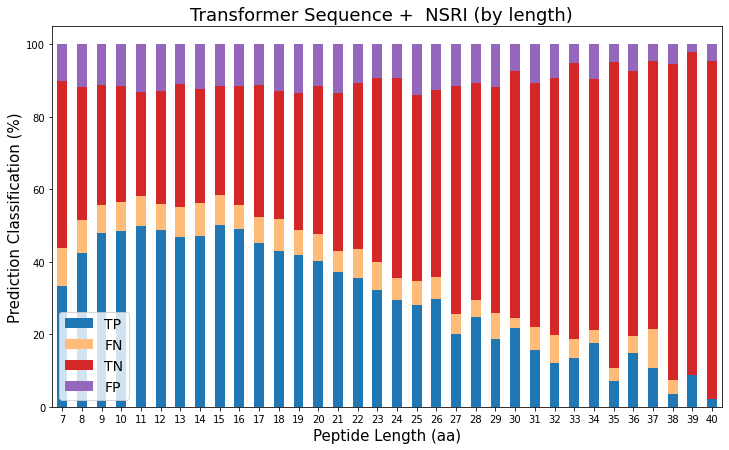

In [15]:
stacked_df = acc_by_len.iloc[:, 1:5].apply(lambda x: x*100/sum(x), axis=1) # calculate the percentage of each 
stacked_df.index = range(7, 41) # set the index to the peptide length

stacked_df.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("tab20", 9)),
          figsize=(12,7))

plt.title("Transformer Sequence +  NSRI (by length)  ", fontsize=18)
plt.xlabel("Peptide Length (aa)", fontsize=15)
plt.ylabel("Prediction Classification (%)", fontsize=15)
plt.legend(fontsize=14)
plt.xticks(rotation=360)
plt.savefig('stacked_confusion_matrix_transformer_20date_sequence_NSRI_minmax_model_no_missed_cleaved22date.png', dpi=600, bbox_inches='tight')


plt.show()